In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
import datetime

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
'''
基本数据导入
'''

In [ ]:
## 四板块
Class = ['券商','银行','房地产','保险']

In [76]:
## 周期数据
## 日度
MacroDataDaily = pd.read_excel('C:/Users/jxjsj/Desktop/宏观经济指标.xlsx').dropna()
MacroDataDaily['M'] = MacroDataDaily['中债国债到期收益率:1年']
MacroDataDaily['C'] = MacroDataDaily['中债企业债到期收益率(AA):3年'] - MacroDataDaily['中债企业债到期收益率(AAA):3年']
## 日期调整 - 月末数据取股票交易日月末
stocktest = pd.read_excel('C:/Users/jxjsj/Desktop/券商.xlsx')['date'].tolist()
MacroDataDaily = MacroDataDaily[MacroDataDaily['date'].isin(stocktest)]
## 月度 - 每月最后一天
MacroDataMonthly = MacroDataDaily.copy()
MacroDataMonthly['trade_date'] = MacroDataDaily['date']
MacroDataMonthly = MacroDataMonthly.set_index('date').apply(lambda x: x.resample('M').last()).reset_index()

In [77]:
## 全数据 - 面板数据堆叠形式
qs = pd.read_excel('C:/Users/jxjsj/Desktop/券商.xlsx')
yh = pd.read_excel('C:/Users/jxjsj/Desktop/银行.xlsx')
fdc = pd.read_excel('C:/Users/jxjsj/Desktop/房地产.xlsx')
bx = pd.read_excel('C:/Users/jxjsj/Desktop/保险.xlsx')

qs['return'] = qs['close']/qs['close'].shift(1)-1
yh['return'] = yh['close']/yh['close'].shift(1)-1
fdc['return'] = fdc['close']/fdc['close'].shift(1)-1
bx['return'] = bx['close']/bx['close'].shift(1)-1

qs['class'] = '券商'
yh['class'] = '银行'
fdc['class'] = '房地产'
bx['class'] = '保险'

FinDataDf = pd.concat([qs,yh,fdc,bx],axis=0,sort=False)

In [78]:
## 起止时间设定
DataStart = '2009-08-31'
StrategyStart = '2013-08-30'
End = '2019-06-30'

MacroDataMonthlySub = MacroDataMonthly[(MacroDataMonthly['trade_date']>=DataStart) & (MacroDataMonthly['trade_date']<=End)].copy()
FinDataDfSub = FinDataDf[(FinDataDf['date']<=End) & (FinDataDf['date']>=DataStart)].copy()
FinDataDfSubReturn = FinDataDfSub.pivot(index='date',columns='class',values='return').reset_index()

In [80]:
## 实行策略时点 - 交易日历的月末
MacroDataMonthlySubForStrategy = MacroDataMonthlySub[MacroDataMonthlySub['trade_date']>=StrategyStart]
StrategyDateDf = MacroDataMonthlySubForStrategy[['trade_date']].rename(columns={'trade_date':'StrategyDate'})
StrategyDateList = StrategyDateDf['StrategyDate'].tolist()

In [81]:
## 基准数据导入
BenchmarkIndex = pd.read_excel('C:/Users/jxjsj/Desktop/中证金融地产.xlsx')
BenchmarkFund = pd.read_excel('C:/Users/jxjsj/Desktop/工银瑞信金融地产.xlsx')

BenchmarkIndex['return'] = BenchmarkIndex['close']/BenchmarkIndex['close'].shift(1)-1
BenchmarkFund['return'] = BenchmarkFund['close']/BenchmarkFund['close'].shift(1)-1

BenchmarkIndexSub = BenchmarkIndex[(BenchmarkIndex['date']>=StrategyStart) & (BenchmarkIndex['date']<=End)]
BenchmarkFundSub = BenchmarkFund[(BenchmarkFund['date']>=StrategyStart) & (BenchmarkFund['date']<=End)]

In [ ]:
'''
策略所需数据/指标/信号计算
'''

In [ ]:
'''
1货币信用周期指标计算
'''

In [82]:
## 货币信用周期指标1 - T~T-3正负占比
def MoneyCredit1(series):
    MList = series.tolist()
    MResultTmp = []
    for i in range(len(MList)-1):
        if MList[-1]-MList[i]>=0:
            MResultTmp.append(1)
        else:
            MResultTmp.append(-1)
    MResult = np.sum(MResultTmp)
    return MResult
MacroDataMonthlySub['DeltaC'] = MacroDataMonthlySub['C'].rolling(4).apply(MoneyCredit1,raw=True)
MacroDataMonthlySub['DeltaM'] = MacroDataMonthlySub['M'].rolling(4).apply(MoneyCredit1,raw=True)
def MCcycle(df):
    if df['DeltaC']>0:
        C='R'
    else:
        C='E'
    if df['DeltaM']>0:
        M='R'
    else:
        M='E'
    return 'M'+M+' C'+C
MacroDataMonthlySub['MCcycle'] = MacroDataMonthlySub.apply(lambda x: MCcycle(x),axis=1)
MCcycleDf = MacroDataMonthlySub[['trade_date','MCcycle']]

In [73]:
'''
2周期表示
'''
CycleList = ['ME CE','ME CR','MR CR','MR CE']

In [ ]:
'''
3各周期与对应月的收益数据合并
'''

In [89]:
## 月收益率
FinDataDfSubClose = FinDataDfSub.pivot(index='date',columns='class',values='close')
FinDataDfSubClose['trade_date'] = FinDataDfSubClose.index
FinDataDfSubReturnM = FinDataDfSubClose.apply(lambda x: x.resample('M').last()).set_index('trade_date').pct_change().reset_index().dropna()

## 收益率与周期合并
CycleAndReturn = FinDataDfSubReturnM.merge(MCcycleDf,on=['trade_date'],how='left')

In [ ]:
'''
4各板块历史排名滚动平均值计算
'''

In [151]:
RollingMonth = 48

# 计算排名序号，按收益率从大到小排序
def RankCompute(df):
    df = df.copy()
    trade_date = df['trade_date'].tolist()[0]
    dfSub = df[Class]
    tmpDf = dfSub.T
    tmpcol = tmpDf.columns.tolist()[0]
    tmpDf0 = tmpDf.sort_values(tmpcol,ascending=False)
    tmpDf0[tmpcol] = range(1,5)
    tmpDf1 = tmpDf0.T[Class]
    tmpDf1.index = [trade_date]
    return tmpDf1

# 并行计算函数
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,sort=False)

# 全周期下历史平均排名
RollingRankAllDf = pd.DataFrame()
for StrategyDate in StrategyDateList:
    CycleAndReturnSub = CycleAndReturn[CycleAndReturn['trade_date']<=StrategyDate].copy()
    CycleAndReturnSub = CycleAndReturnSub.iloc[-RollingMonth:,:]
    # 并行计算
    RollingRankGroupby = CycleAndReturnSub.groupby('trade_date')
    RollingRankMaterial = applyParallel(RollingRankGroupby, RankCompute)
    
#     RollingRankMaterial.index = RollingRankMaterial.index.droplevel(1)
    RollingRank = RollingRankMaterial.mean().to_frame().T
    RollingRank.index = [StrategyDate]
    RollingRankAllDf = pd.concat([RollingRankAllDf,RollingRank],axis=0)
RollingRankAllDf.columns = [i+'RankAll' for i in RollingRankAllDf.columns]

# 当前周期的历史同周期平均排名
RollingRankCycleDf = pd.DataFrame()
for StrategyDate in StrategyDateList:
    CycleAndReturnSub = CycleAndReturn[CycleAndReturn['trade_date']<=StrategyDate].copy()
    CycleAndReturnSub = CycleAndReturnSub.iloc[-RollingMonth:,:]
    CycleNow = CycleAndReturnSub['MCcycle'].tolist()[-1]
    CycleAndReturnSub = CycleAndReturnSub[CycleAndReturnSub['MCcycle']==CycleNow]
    # 并行计算
    RollingRankGroupby = CycleAndReturnSub.groupby('trade_date')
    RollingRankMaterial = applyParallel(RollingRankGroupby, RankCompute)
    
#     RollingRankMaterial.index = RollingRankMaterial.index.droplevel(1)
    RollingRank = RollingRankMaterial.mean().to_frame().T
    RollingRank.index = [StrategyDate]
    RollingRankCycleDf = pd.concat([RollingRankCycleDf,RollingRank],axis=0)
RollingRankCycleDf.columns = [i+'RankCycle' for i in RollingRankCycleDf.columns]

In [ ]:
'''
5排名+周期+月度+收益率拼接 - 底稿
'''

In [156]:
AllDataForBackTest = CycleAndReturn.merge(RollingRankCycleDf.merge(RollingRankAllDf,left_index=True,right_index=True),left_on='trade_date',right_index=True,how='left')
AllDataForBackTest.to_excel('C:/Users/jxjsj/Desktop/AllDataForBackTest.xlsx',index=False)

In [ ]:
'''
回测部分
'''

In [ ]:
'''
回测函数
'''

In [171]:
### 策略函数
def Strategy(df,HowRank,RankN):
    '''
    输入当天底稿数据，最终排名方法（偏离度排名，绝对排名），取前几名
    输出所有资产对应目标权重
    '''
    df_ = df.copy()
    if HowRank == '偏离度排名':
        for EachClass in Class:
            df_[EachClass] = df_[EachClass+'RankAll'] - df_[EachClass+'RankCycle']
            ascending=False
    if HowRank == '绝对排名':
        for EachClass in Class:
            df_[EachClass] = df_[EachClass+'RankCycle']
            ascending=True
    ResultDf = df_[Class].T
    ResultDf = ResultDf.sort_values(ResultDf.columns[0],ascending=ascending)
    ResultDf[ResultDf.columns[0]] = range(1,5)
    ResultDf[ResultDf.columns[0]] = ResultDf[ResultDf.columns[0]].apply(lambda x: 1/RankN if x<=RankN else 0)
    expected_stock_weight = ResultDf.T[Class]
    return expected_stock_weight

In [197]:
### 结算函数 - 月度结算
def Clear(df,tol_equity,expected_stock_weight):
    '''
    输入下一个月数据，要包含本月最后一天（用以计算收益率）、结算前净值（初始值为1）、目标权重
    输出下一个月净值序列（月初-月末）
    '''
    df_ = df.copy()
    expected_stock_w = expected_stock_weight.copy()
    
    # 相对增长 Pt/Pt-1 序列
    df_ = df_.pivot_table(index='date',columns='class',values='close').fillna(method='ffill').dropna()[Class]
    df_ = df_.pct_change().dropna()
    df_ = df_+1
    
    # 初始净值分配到各个资产上，乘以累计相对增长得到净值序列，丢弃首行拼接  
    stock_w = expected_stock_w.apply(lambda x: x*tol_equity)

    equity_tmp = pd.concat([stock_w,df_],axis=0,sort=False)
    equity_df = equity_tmp.cumprod().sum(axis=1).to_frame('equity_series').iloc[1:,]
    
    return equity_df, equity_df['equity_series'][-1]

In [198]:
### 分析函数 - 计算各类指标
def Indicator(equity_df):
    '''
    输入净值序列
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    df['return'] = df['equity_series']/df['equity_series'].shift(1)-1
    df['drawdown'] = 1-df['equity_series']/df['equity_series'].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df['equity_series'][-1]/df['equity_series'][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 最大回撤时间
#     end_max_drawdown = df['drawdown'].idxmax()
#     df_sub = df[df.index<=end_max_drawdown]
#     start_max_drawdown = df_sub[df_sub['drawdown']==0].index[-1]
#     end_max_drawdown = datetime.datetime.strptime(end_max_drawdown,'%Y-%m-%d')
#     start_max_drawdown = datetime.datetime.strptime(start_max_drawdown,'%Y-%m-%d')
#     max_drawdown_day = (end_max_drawdown - start_max_drawdown).days
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = df['return'].mean()*252
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 夏普比率
#     sharpe_ratio = (mean_return-rf)/vol_return

    output_dict = {'cum_return':[cum_return],
                   'max_drawdown':[max_drawdown],
                   'cum_return_drawdown_ratio':[cum_return_drawdown_ratio],
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                  }
    output_df = pd.DataFrame(output_dict,index=[HowRank+str(RankN)]).T
    return output_df, df

In [ ]:
'''
回测调参
'''

In [218]:
## 回测 - 调参

for HowRank in ['偏离度排名','绝对排名']:
    for RankN in [1,2]:
        # 初始化指标
        tol_equity = 1
        HowRank = HowRank
        RankN = RankN
        equity_df = pd.DataFrame([1],columns=['equity_series'],index=[StrategyDateList[0]])
        # 月末循环执行策略，最后一个月不执行策略
        for cnt in range(len(StrategyDateList)-1):

            # 获取关键日期
            strategy_date = StrategyDateList[cnt]
            next_strategy_date = StrategyDateList[cnt+1]

            # 读取数据 - 历史策略用数据+未来一个月收益率计算数据
            # 历史策略用数据
            history_data = AllDataForBackTest[AllDataForBackTest['trade_date'] == strategy_date]

            # 读取数据 - 未来一个月收益率计算数据 
            future_data_for_return = FinDataDf[(FinDataDf['date']<=next_strategy_date) & (FinDataDf['date']>=strategy_date)]

            # 运行策略
            expected_weight_df = Strategy(history_data, HowRank, RankN)

            # 结算策略，更新净值
            clear_df, tol_equity = Clear(future_data_for_return,tol_equity,expected_weight_df)

            # 输出净值序列
            equity_df = pd.concat([equity_df,clear_df],axis=0)

        backtest = Indicator(equity_df)
        # 策略结果
        print('Strategy')
        print(backtest[0])

Strategy
                             偏离度排名1
cum_return                 2.988275
max_drawdown               0.494725
cum_return_drawdown_ratio  6.040275
mean_return                0.302410
vol_return                 0.337308
Strategy
                             偏离度排名2
cum_return                 2.265958
max_drawdown               0.460300
cum_return_drawdown_ratio  4.922784
mean_return                0.256069
vol_return                 0.302789
Strategy
                              绝对排名1
cum_return                 2.079969
max_drawdown               0.494725
cum_return_drawdown_ratio  4.204292
mean_return                0.259995
vol_return                 0.347527
Strategy
                              绝对排名2
cum_return                 1.179183
max_drawdown               0.497482
cum_return_drawdown_ratio  2.370301
mean_return                0.182635
vol_return                 0.297344


In [221]:
# 中证金融地产指数
BenchmarkIndexSubEquity = BenchmarkIndexSub.rename(columns={'close':'equity_series'}).set_index('date')[['equity_series']]
BenchmarkIndexSubEquityFirst = BenchmarkIndexSubEquity['equity_series'].tolist()[0]
BenchmarkIndexSubEquity['equity_series'] = BenchmarkIndexSubEquity['equity_series'].apply(lambda x: x/BenchmarkIndexSubEquityFirst)
print('Index')
print(Indicator(BenchmarkIndexSubEquity)[0])
# 工银瑞信金融地产基金
BenchmarkFundSubEquity = BenchmarkFundSub.rename(columns={'close':'equity_series'}).set_index('date')[['equity_series']]
BenchmarkFundSubEquityFirst = BenchmarkFundSubEquity['equity_series'].tolist()[0]
BenchmarkFundSubEquity['equity_series'] = BenchmarkFundSubEquity['equity_series'].apply(lambda x: x/BenchmarkFundSubEquityFirst)
print('\nFund')
print(Indicator(BenchmarkFundSubEquity)[0])

Index
                              绝对排名2
cum_return                 0.872944
max_drawdown               0.436689
cum_return_drawdown_ratio  1.999007
mean_return                0.145751
vol_return                 0.261278

Fund
                              绝对排名2
cum_return                 1.461078
max_drawdown               0.448810
cum_return_drawdown_ratio  3.255452
mean_return                0.194116
vol_return                 0.258868


In [ ]:
'''
最优结果输出
'''

In [223]:
## 回测 - 最优结果


# 初始化指标
tol_equity = 1
HowRank = '偏离度排名'
RankN = 1
equity_df = pd.DataFrame([1],columns=['equity_series'],index=[StrategyDateList[0]])
# 月末循环执行策略，最后一个月不执行策略
for cnt in range(len(StrategyDateList)-1):

    # 获取关键日期
    strategy_date = StrategyDateList[cnt]
    next_strategy_date = StrategyDateList[cnt+1]

    # 读取数据 - 历史策略用数据+未来一个月收益率计算数据
    # 历史策略用数据
    history_data = AllDataForBackTest[AllDataForBackTest['trade_date'] == strategy_date]

    # 读取数据 - 未来一个月收益率计算数据 
    future_data_for_return = FinDataDf[(FinDataDf['date']<=next_strategy_date) & (FinDataDf['date']>=strategy_date)]

    # 运行策略
    expected_weight_df = Strategy(history_data, HowRank, RankN)

    # 结算策略，更新净值
    clear_df, tol_equity = Clear(future_data_for_return,tol_equity,expected_weight_df)

    # 输出净值序列
    equity_df = pd.concat([equity_df,clear_df],axis=0)

backtest = Indicator(equity_df)
# 策略结果
print('Strategy')
print(backtest[0])

Strategy
                             偏离度排名1
cum_return                 2.988275
max_drawdown               0.494725
cum_return_drawdown_ratio  6.040275
mean_return                0.302410
vol_return                 0.337308


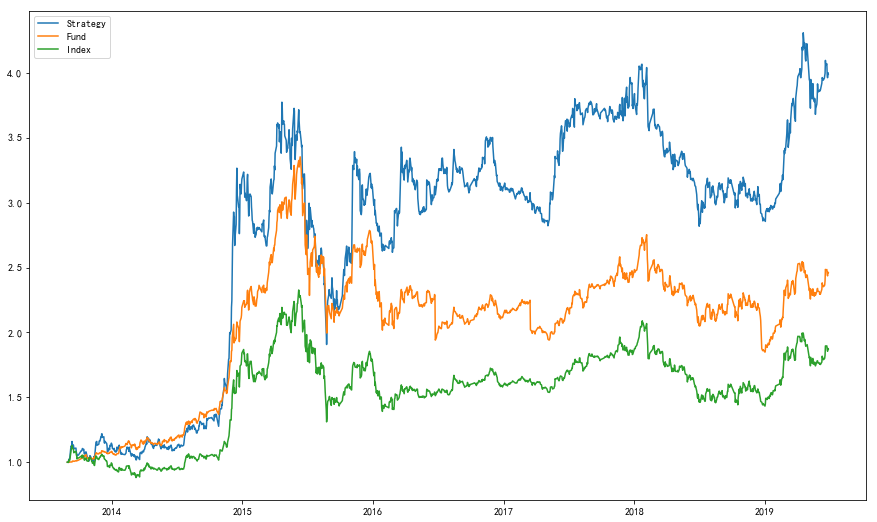

In [224]:
plt.figure(figsize=(15,9))
plt.plot(backtest[1][['equity_series']],label='Strategy')
plt.plot(BenchmarkFundSubEquity[['equity_series']],label='Fund')
plt.plot(BenchmarkIndexSubEquity[['equity_series']],label='Index')
plt.legend(loc=0)